# Deep Hedging AI
### Convergence to Black & Scholes Delta
#### Base case: BS with (statistical) drift 0.1, cvar@1, 400 epochs, zero cost, 50000 path
#### This file: no drift, exp2 utility

Hans Buehler, January 2nd, 2023


In [1]:
!pip -q install cdxbasics "tensorflow==2.10" "tensorflow_probability==0.14"
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello  ... 

2023-01-18 08:36:07.516957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 08:36:07.660949: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-01-18 08:36:09.486754: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-18 08:36:09.486799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-12-144.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist


## Deep Hedging in a Black \& Scholes World

2023-01-18 08:36:10.668138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Gym with 6763 trainable weights compiled and initialized. Took 4s
Network feature information:
 Features used by the agent:        delta, price and time_left
 Features available to the agent:   action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by the utility:      -
 Features available to the utility: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/blackscholes/.deephedging_cache/1cc1655e62a600f73d12a98a4e8a7439.pck'
Cache successfully loaded. Current epoch: 433
Training monitor initialized. Took 0s



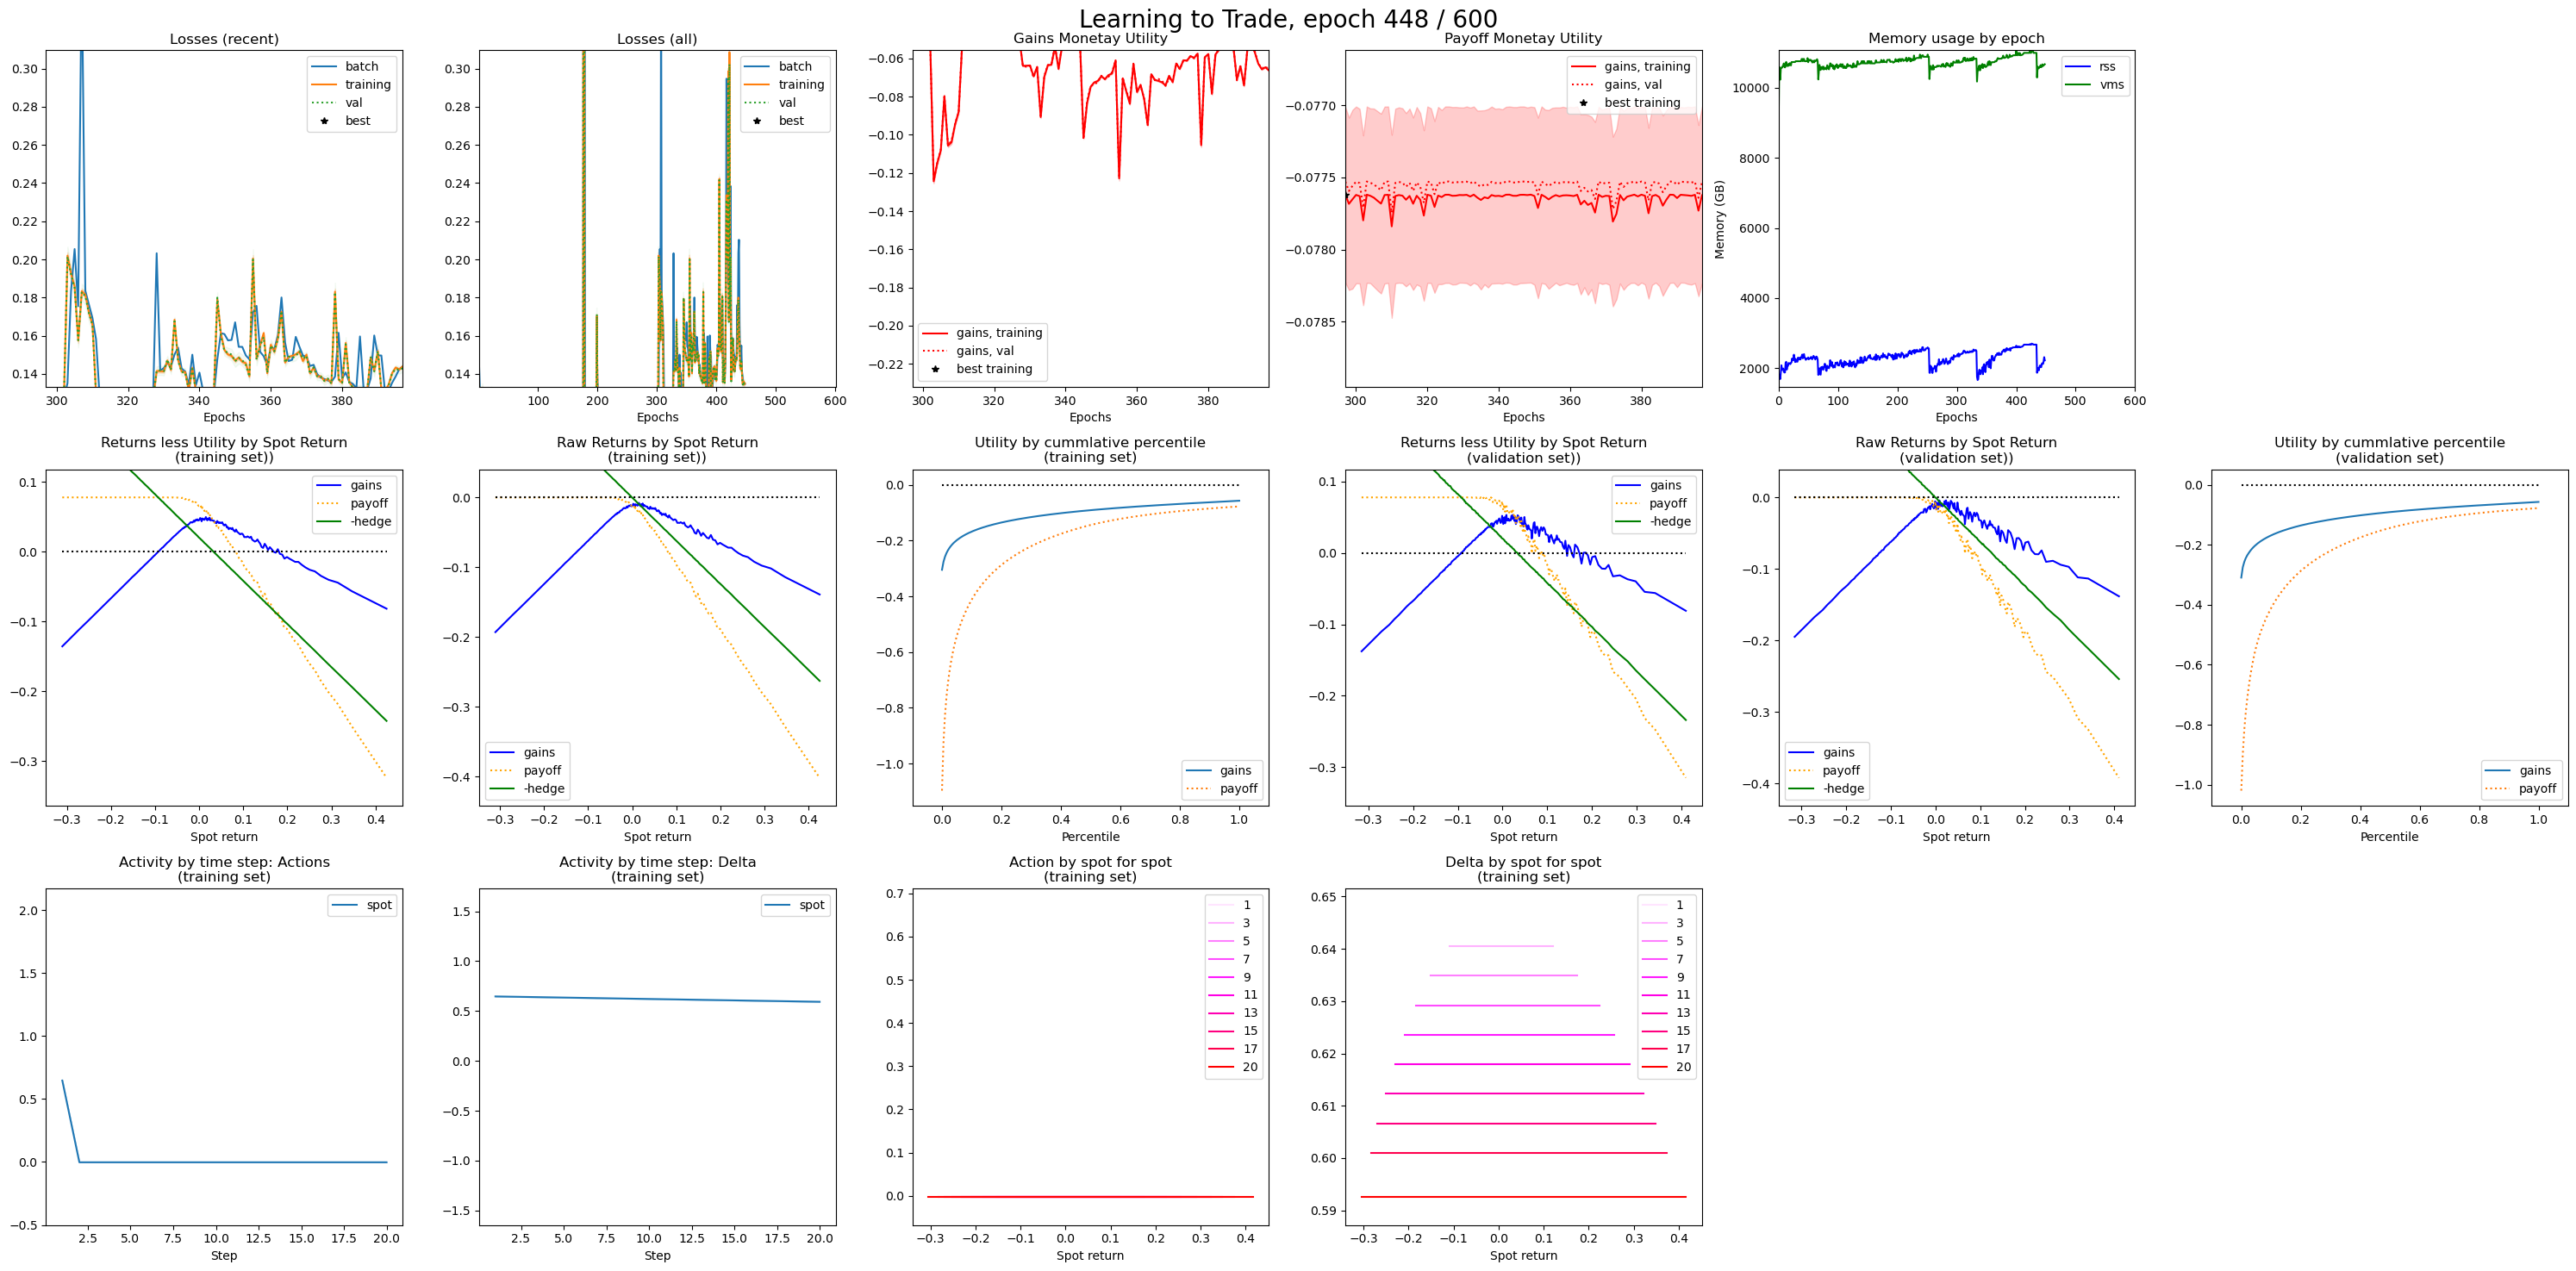

Training 448/600 epochs; 6763 weights; 50000 samples; 5000 validation samples batch size 32 | initial loss 2.18417 (0.0235363), training 0.134987 (0.000701657), best 0.127227 (0.0235363), batch 0.134592, val 0.134858 (0.00220369). Best epoch 296; last cached 440. | memory used: rss 2225.93M, vms 10672.4M | time elapsed 10:31:19; time per epoch 1:24; estimated time remaining 14:05:31                        

In [ ]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 50000
config.world.steps = 20
config.world.black_scholes = True
config.world.rvol = 0.2    # 20% volatility
config.world.drift = 0.   # real life drift
config.world.cost_s = 0.
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 10.
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 40
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 0.5
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 600
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world & validation world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=config.world("samples")//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [ ]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

display(Markdown("## Hedging results in detail"))
plot_bs_hedge.plot_blackscholes( world, gym, config )
